# Working with Instrumental Descriptions

the instrumental description is loaded by the event source, and consists of a hierarchy of classes in the ctapipe.instrument module, the base of which is the `SubarrayDescription`

First, let's open a file and load a single event so we get the instrument info in the event.inst container.

In [1]:
from ctapipe.utils.datasets import get_dataset
from ctapipe.io.hessio import hessio_event_source
import numpy as np

#filename = get_dataset("gamma_test_large.simtel.gz") # try this one as well
filename = get_dataset("gamma_test.simtel.gz")  


source = hessio_event_source(filename)
event = next(source)
del source # close the file

### now let's play with the SubarrayDescription:

In [2]:
subarray = event.inst.subarray

subarray.info()

Subarray : MonteCarloArray
Num Tels : 126
Footprint: 7.32 km2

                TYPE  Num IDmin  IDmax
          LST:LSTCam    4    1 ..   4
       MST:NectarCam   24    5 ..  28
      SST-ASTRI:CHEC   72   29 .. 100
      MST-SCT:SCTCam   26  101 .. 126


In [3]:
subarray.to_table()

tel_id,tel_pos_x,tel_pos_y,tel_type,tel_subtype,mirror_type,camera_type,tel_description
,m,m,,,,,
int16,float64,float64,str3,str5,str2,str9,str14
1,50.0,50.0,LST,,DC,LSTCam,LST:LSTCam
2,-50.0,50.0,LST,,DC,LSTCam,LST:LSTCam
3,50.0,-50.0,LST,,DC,LSTCam,LST:LSTCam
4,-50.0,-50.0,LST,,DC,LSTCam,LST:LSTCam
5,141.100006104,0.0,MST,,DC,NectarCam,MST:NectarCam
6,-141.100006104,0.0,MST,,DC,NectarCam,MST:NectarCam
7,0.0,55.4000015259,MST,,DC,NectarCam,MST:NectarCam
8,298.399993896,66.9000015259,MST,,DC,NectarCam,MST:NectarCam


You can also get a table of just the `OpticsDescriptions` (`CameraGeometry` is more complex and can't be stored on a single table row, so each one can be converted to a table separately)

In [4]:
subarray.to_table(kind='optics')

tel_type,tel_subtype,mirror_area,mirror_type,num_mirror_tiles,equivalent_focal_length
,,m2,,,m
str3,str5,float64,str2,int64,float64
MST,SCT,73.3475723267,SC,2,5.58629989624
MST,,103.830558777,DC,84,16.0
SST,ASTRI,14.5625667572,SC,2,2.15000009537
LST,,386.751556396,DC,198,28.0


Make a sub-array with only SC-type telescopes:

In [5]:
tab = subarray.to_table()
sc_tels = tab[tab['mirror_type']=='SC']['tel_id']  # select tel_id of entries where the mirror type is SC
newsub = subarray.select_subarray("SCTels", sc_tels)
newsub.info()

Subarray : SCTels
Num Tels : 98
Footprint: 7.32 km2

                TYPE  Num IDmin  IDmax
      SST-ASTRI:CHEC   72   29 .. 100
      MST-SCT:SCTCam   26  101 .. 126


can also do this by using `Table.group_by`

In [6]:
gtab = tab.group_by('mirror_type')
sc = gtab.groups[1]
newsub = subarray.select_subarray("SCTels", sc['tel_id'])
newsub.info()

Subarray : SCTels
Num Tels : 98
Footprint: 7.32 km2

                TYPE  Num IDmin  IDmax
      SST-ASTRI:CHEC   72   29 .. 100
      MST-SCT:SCTCam   26  101 .. 126


### Explore some of the details of the telescopes

In [7]:
tel = subarray.tel[5]
tel

TelescopeDescription(optics=MST, camera=NectarCam)

In [8]:
tel.optics.mirror_area

<Quantity 103.83055877685547 m2>

In [9]:
tel.optics.num_mirror_tiles

84

In [10]:
tel.optics.equivalent_focal_length

<Quantity 16.0 m>

In [11]:
tel.camera

CameraGeometry(cam_id='NectarCam', pix_type='hexagonal', npix=1855, cam_rot=0.0 deg, pix_rot=100.893 deg)

In [12]:
tel.camera.pix_x

<Quantity [ 0.        ,-0.00944877,-0.0472442 ,..., -0.6519913 ,
           -0.6141959 ,-0.62364467] m>

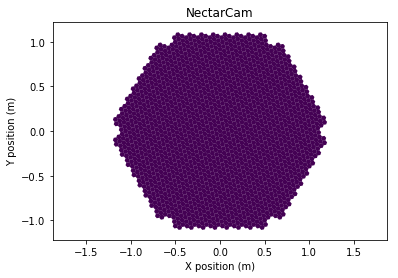

In [13]:
%matplotlib inline
from ctapipe.visualization import CameraDisplay
CameraDisplay(tel.camera)

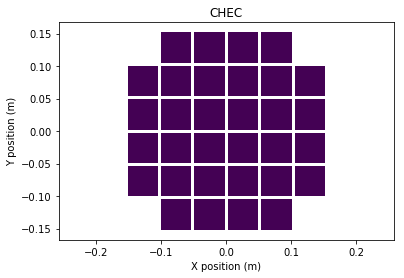

In [14]:
CameraDisplay(subarray.tel[98].camera)

## Plot the subarray

We'll make a subarray by telescope type and plot each separately, so they appear in different colors.  We also calculate the radius using the mirror area (and exagerate it a bit).

This is just for debugging and info, for any "real" use, a `visualization.ArrayDisplay` should be used

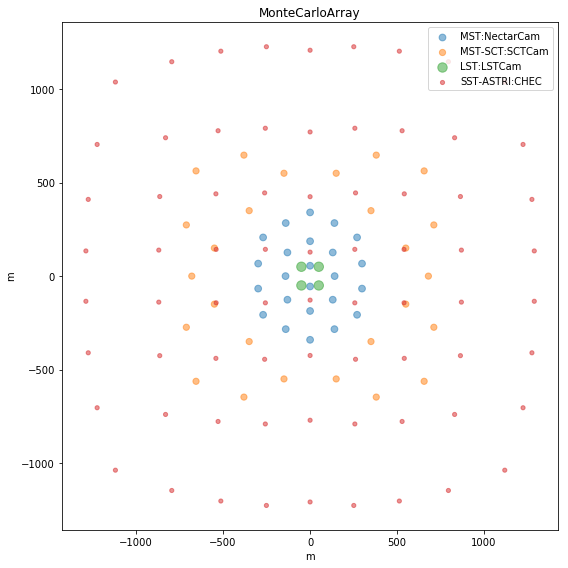

In [15]:
subarray.peek()

In [16]:
subarray.footprint

<Quantity 7.316612241794466 km2>

### With Pandas
If you prefer working with *Pandas* `DataFrames` instead of *AstroPy* `Tables`, you can always convert between the two:

In [17]:
df = subarray.to_table().to_pandas()
df.set_index('tel_id')

,tel_pos_x,tel_pos_y,tel_type,tel_subtype,mirror_type,camera_type,tel_description
tel_id,,,,,,,
1,50.000000,50.000000,LST,,DC,LSTCam,LST:LSTCam
2,-50.000000,50.000000,LST,,DC,LSTCam,LST:LSTCam
3,50.000000,-50.000000,LST,,DC,LSTCam,LST:LSTCam
4,-50.000000,-50.000000,LST,,DC,LSTCam,LST:LSTCam
5,141.100006,0.000000,MST,,DC,NectarCam,MST:NectarCam
6,-141.100006,0.000000,MST,,DC,NectarCam,MST:NectarCam
7,0.000000,55.400002,MST,,DC,NectarCam,MST:NectarCam
8,298.399994,66.900002,MST,,DC,NectarCam,MST:NectarCam
9,-298.399994,66.900002,MST,,DC,NectarCam,MST:NectarCam


In [18]:
g = df.groupby('tel_description')
g.groups

{'LST:LSTCam': Int64Index([0, 1, 2, 3], dtype='int64'),
 'MST-SCT:SCTCam': Int64Index([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
             113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125],
            dtype='int64'),
 'MST:NectarCam': Int64Index([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
             21, 22, 23, 24, 25, 26, 27],
            dtype='int64'),
 'SST-ASTRI:CHEC': Int64Index([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
             45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
             62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
             79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
             96, 97, 98, 99],
            dtype='int64')}

In [19]:
g.groups['LST:LSTCam']

Int64Index([0, 1, 2, 3], dtype='int64')

In [20]:
df.loc[g.groups['LST:LSTCam']]

,tel_id,tel_pos_x,tel_pos_y,tel_type,tel_subtype,mirror_type,camera_type,tel_description
0,1,50.0,50.0,LST,,DC,LSTCam,LST:LSTCam
1,2,-50.0,50.0,LST,,DC,LSTCam,LST:LSTCam
2,3,50.0,-50.0,LST,,DC,LSTCam,LST:LSTCam
3,4,-50.0,-50.0,LST,,DC,LSTCam,LST:LSTCam


Subarray : LSTs
Num Tels : 4
Footprint: 0.02 km2

                TYPE  Num IDmin  IDmax
          LST:LSTCam    4    1 ..   4


<Quantity 0.015707963267948967 km2>

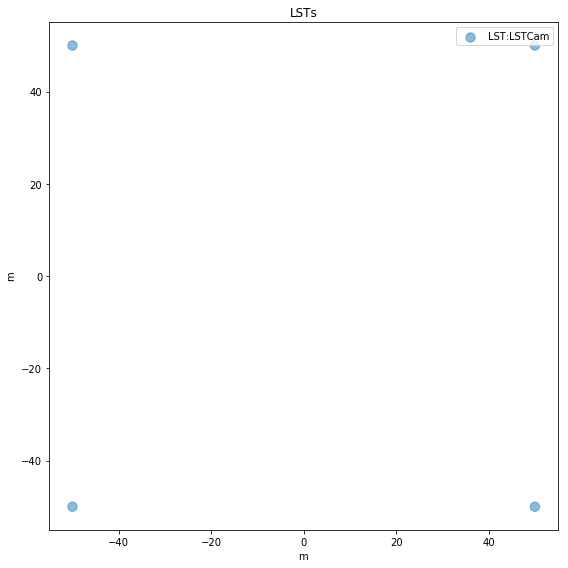

In [21]:
lsts = subarray.select_subarray("LSTs", df.loc[g.groups['LST:LSTCam']]['tel_id'])
lsts.info()
lsts.peek()
lsts.footprint